<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/pipeline_123_classifier_LDA_SVM_databalance_dataset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Based on the confusion matrix, try to augment some of the categories by increasing the number of the example in the category.
LDA + regression has a hard time telling
  - 0 from 3,4
  - 1 from 2
  - 3 from 0
  - 4 from 1,2

SVM has a hard time telling
  - 0 from 3
  - 1 from 2
  - 3 from 0
  - 4 from 1,2

where we have 500 examples for each class
0,1,2,3,4 represent Cigar-shaped smooth, completely round smooth, edge-on, In between smooth, spiral

since we only have 579 examples in class 0, take
class 0: 579
class 1: 1000
class 2: 1000
class 3: 600
class 4: 1000
as data set 2
expecting the model can learn more from class 1,2,4 and improve the recall/precision of these classes but keep the performance of class 0 and class 3

further increase the number of examples for each class
data set 3
class 0: 579
class 1: 1500
class 2: 1500
class 3: 1000
class 4: 1500

data set 4
use all examples we have
Cigar-Shaped Smooth: 579
In-between Smooth: 8069
Complete Round Smooth: 8436
Edge-on: 3903
Spiral: 7806

"""

from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# copy the filters from ex7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color
from scipy.cluster.vq import kmeans
np.random.seed(62)
from scipy.cluster.vq import vq

In [3]:
# training data
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_3.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)
print(df_train.shape)
# val data
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/val_data_3.csv'
column_names = ['path', 'index', 'label']
df_val = pd.read_csv(csv_file_path, names=column_names)
df_val = df_val.iloc[1:]
df_val = df_val.reset_index(drop=True)
print(df_val.shape)

(4863, 3)
(608, 3)


In [4]:
# preprocess and pipeline
from tqdm import tqdm


def grayscale_preprocessing(img):
	if np.max(img) > 1:
		img = img.astype(np.float32) / 255.0
	im_gray = np.mean(img, axis=2)
	return im_gray


def bilateral_preprocessing(img, ksize, sigmX, sigmY):
	bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
	return bilateral_filtered_image


def high_pass_preprocessing(img, ksize, sig):
	low_pass = cv2.GaussianBlur(img, ksize, 0)
	high_pass = img - low_pass
	return high_pass


def build_codebook(
	preprocessed_features,
	sample_size=1050,
	k=200,
	iters=1,
	save_location="codebook.npy",
):
	"""
	Use k-means clustering to build a codebook of visual words, given a set of SIFT descriptors.
	Args:
					sample_size: number of SIFT descriptors to sample from the training set
	"""
	descriptors_sample = list()
	descriptor_sample = list()
	sample_idx = np.random.randint(0, len(df_train) + 1, sample_size).tolist()
	for i in sample_idx:
		if (
			preprocessed_features[i] is not None
			and len(preprocessed_features[i].shape) == 2
		):
			descriptors_sample.append(preprocessed_features[i])
	descriptor_sample = np.vstack(descriptors_sample)
	codebook, variance = kmeans(descriptor_sample, k, iters)
	np.save(save_location, codebook)
	return codebook


def quantize_and_create_sparse_representation(preprocessed_features, codebook):
	visual_words = []
	frequency_vectors = []
	# for each image descriptor, take every idx and
	for img_descriptors in preprocessed_features:
		if img_descriptors is None:
			visual_words.append(np.zeros(200))
			continue
		img_visual_words, distance = vq(img_descriptors, codebook)
		visual_words.append(img_visual_words)
	for img_visual_words in visual_words:
		# create a frequency vector for each image
		img_frequency_vector = np.zeros(200)
		for word in img_visual_words:
			img_frequency_vector[int(word)] += 1
		frequency_vectors.append(img_frequency_vector)
	frequency_vectors = np.stack(frequency_vectors)
	return frequency_vectors


def sift_bag_of_visual_words(img):
	sift = cv2.SIFT_create()
	image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
	keypoints, descriptors = sift.detectAndCompute(image8bit, None)
	return descriptors


def sobel_preprocessing(img, ksize):
	sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)  # Find x and y gradients
	sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
	magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
	if np.max(magnitude) == 0:
		return magnitude
	magnitude = magnitude / np.max(magnitude)  # normalize
	return magnitude


def gaussian_blur_preprocessing(img, ksize, sigma):
	blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
	return blurred_im


def canny_filter(img, high_threshold, low_threshold):
	# ensure the image is normalized to the range [0, 1]
	if np.max(img) != 0:
		img = img / np.max(img)
	# scale the image to the range [0, 255] and convert to 8-bit
	img_8u = np.uint8(img * 255)
	# threshold the image and get the interesting points
	# The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
	# The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
	# By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

	im_threshold = cv2.Canny(
		image=img_8u, threshold1=low_threshold, threshold2=high_threshold
	)  # Canny Edge
	if np.max(im_threshold) == 0:
		return im_threshold
	im_threshold = im_threshold / np.max(im_threshold)  # normalize
	return im_threshold


def crop_center(img, cropx, cropy):
	y, x = img.shape
	startx = x // 2 - (cropx // 2)
	starty = y // 2 - (cropy // 2)
	return img[starty : starty + cropy, startx : startx + cropx]


def histogram_clipping(img, threshold_value):
	clipped_image = img.copy()
	# before
	# draw_histogram_gray(clipped_image)
	clipped_image[img < threshold_value / 255.0] = 0
	# Normalize the clipped_image to 0-255 for proper histogram visualization
	normalized_clipped_image = cv2.normalize(
		clipped_image,
		None,
		alpha=0,
		beta=255,
		norm_type=cv2.NORM_MINMAX,
		dtype=cv2.CV_8UC1,
	)
	# draw_histogram_gray(clipped_image)
	return normalized_clipped_image


def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
	block_norm = "L1"  # Block normalization method
	# orientations = 9   # Number of orientation bins
	# pixels_per_cell = (8, 8)  # Size of the cell
	# cells_per_block = (3, 3)  # Size of the block

	# Compute the HOG features
	hog_features, hog_image = feature.hog(
		img_gray,
		orientations=orientations,
		pixels_per_cell=pixels_per_cell,
		cells_per_block=cells_per_block,
		block_norm=block_norm,
		visualize=True,
	)
	return hog_features, hog_image


def preprocess_1(df, codebook=None):
	image_dir = df["path"]  # ignore index
	preprocessed_list = []
	for i, image_path in enumerate(tqdm(image_dir)):
		im = np.array(Image.open(image_path))
		im = grayscale_preprocessing(im)
		im= histogram_clipping(im, 30)
		im = gaussian_blur_preprocessing(
			im, (9, 9), (10, 10)
		)
		im = bilateral_preprocessing(im, 5, 30, 30)
		im = sobel_preprocessing(im, 31)
		im = canny_filter(im, 70, 0)
		im = crop_center(im, 252, 252)
		sift = sift_bag_of_visual_words(im)
		preprocessed_list.append(sift)
	if codebook is None:
		codebook = build_codebook(preprocessed_list)
	frequency_vectors = quantize_and_create_sparse_representation(
		preprocessed_list, codebook
	)
	#max = np.max(frequency_vectors, axis=1)
	#vector_representations_normalized = frequency_vectors / max[:, np.newaxis]
	# im_flattened = im_cropped.flatten(
	return frequency_vectors


def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(tqdm(image_dir)):
    im = np.array(Image.open(image_path))

    im = grayscale_preprocessing(im)
    im = histogram_clipping(im, 30)
    im = gaussian_blur_preprocessing(im, (9, 9), (10, 10))
    im = bilateral_preprocessing(im, 5, 30, 30)
    im = crop_center(im, 240, 240)
    hog_feature, hog_image = hog(im) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed


def preprocess_resnet_nopreprocess(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(tqdm(image_dir)):
    im = np.array(Image.open(image_path))
    preprocessed_list.append(im)
  return preprocessed_list

In [5]:
from sklearn.decomposition import PCA


def pick_top_feature_pca(feature_matrix, top_components, n_components):
		# pick up top 100 features by PCA
		pca = PCA(n_components=n_components)
		pca.fit(feature_matrix)
		principal_components = pca.transform(feature_matrix)
		top_components_matrix = principal_components[:, :top_components]

		plt.figure(figsize=(8, 4))
		plt.plot(np.cumsum(pca.explained_variance_ratio_))
		plt.xlabel("Number of PCA components")
		plt.ylabel("Cumulative explained variance")
		plt.title("Explained Variance vs Number of PCA Components")
		plt.grid(True)
		plt.show()
		# Extract the top n components
		return top_components_matrix, pca

# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
  principal_components = pca_train.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]
  return top_components_matrix

Resnet50

In [6]:
images_list_nopreprocess_1 = preprocess_resnet_nopreprocess(df_train[:1800])

100%|██████████| 1800/1800 [16:50<00:00,  1.78it/s]


In [7]:
images_list_nopreprocess_2 = preprocess_resnet_nopreprocess(df_train[1800:])
images_list_nopreprocess = images_list_nopreprocess_1 + images_list_nopreprocess_2
print(len(images_list_nopreprocess))

100%|██████████| 3063/3063 [27:47<00:00,  1.84it/s]

4863


In [8]:
images_list_nopreprocess_val = preprocess_resnet_nopreprocess(df_val)
print(len(images_list_nopreprocess_val))

100%|██████████| 608/608 [05:09<00:00,  1.96it/s]

608


In [32]:
import torch
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# remove the classifier on top of resnet
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
# freeze the parameters of the feature extractor
for param in resnet.parameters():
    param.requires_grad = False
# Print the modified ResNet architecture

# print(resnet)

# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.6MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [27]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# data loader
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img

# transformations to be applied to the images
transform = transforms.Compose([
    # crop the image to shape of 224,224 in preprocess stage
    transforms.Resize(256),  # Step 1: Resize to 256x256
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# function to preprocess an image
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray(img)
        processed_image = transform(img).unsqueeze(0)  # Add batch dimension
        processed_images.append(processed_image)
    return processed_images


custom_dataset = CustomDataset(images_list_nopreprocess, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in tqdm(data_loader):
        features = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features = torch.cat(features_list, dim=0)

print(features.shape)

In [ ]:
# val
custom_dataset_val = CustomDataset(images_list_nopreprocess_val, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in tqdm(data_loader):
        features_val = resnet(batch.to(device))
        features_list.append(features_val)

# Concatenate features from all batches
features_val = torch.cat(features_list, dim=0)

print(features_val.shape)

In [ ]:
import pandas as pd

features = features.cpu()
# reshape it to 2000,2048
reshaped_features = features.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)
# Convert to DataFrame
df_features = pd.DataFrame(reshaped_features)
# Display the DataFrame
print(df_features.shape)
df_features.head(3)

In [13]:
features_val = features_val.cpu()
reshaped_features_val = features_val.squeeze().numpy()
reshaped_features_val = reshaped_features_val.reshape(reshaped_features_val.shape[0], -1)
df_features_val = pd.DataFrame(reshaped_features_val)
print(df_features_val.shape)
df_features_val.head(3)


(608, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.511675,0.533254,0.563367,0.284694,0.806230,0.198125,0.465022,0.638722,0.301808,0.214367,...,0.101777,0.165638,0.675202,0.093879,0.492716,0.059973,0.184933,0.092644,0.190427,0.589083
1,0.216611,0.835735,0.309392,0.229718,0.434089,0.121459,0.068209,0.301345,0.364540,0.045816,...,0.266040,0.207628,0.561606,0.232925,0.498660,0.155736,0.665337,0.616801,0.093346,0.182054
2,0.144118,0.164493,0.823834,0.390436,0.238070,0.467705,0.221653,0.585335,0.254989,0.511982,...,0.247092,0.360332,0.330096,0.479710,0.320026,0.243605,0.271338,0.512784,0.404681,0.291123


In [ ]:
df_features.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_resnet_beforepca_3.csv", index=False)
df_features_val.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_resnet_beforepca_3.csv", index=False)

# df_features = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_resnet_beforepca_3.csv")
# df_features_val = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_resnet_beforepca_3.csv")

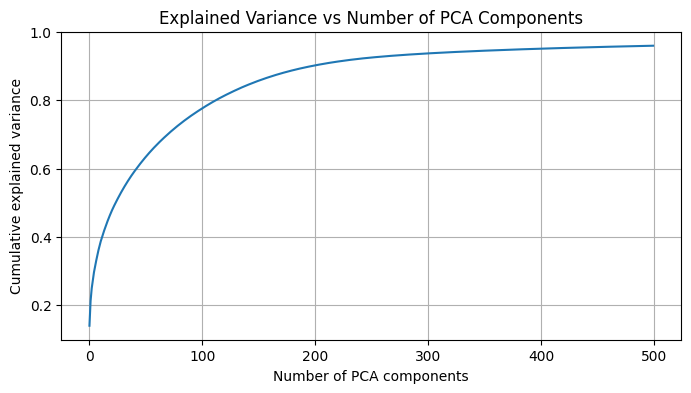

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-4.204023,-0.040618,1.255075,0.377362,-3.966708,-0.574764,-1.910764,-0.803092,-3.428433,1.617188,...,-0.112989,0.286828,-0.266272,0.462070,0.870207,-0.466954,0.000849,0.572467,1.240376,-0.017108
1,-2.134757,-0.899995,-1.916504,-2.481378,0.396296,0.341608,0.436593,0.683154,0.187070,0.880760,...,-0.900413,0.402280,-0.420124,0.193711,-0.166851,0.398618,0.165682,0.129602,-0.340085,0.453880
2,2.314599,-3.921500,1.211901,0.295598,1.030369,-1.052456,0.221823,-0.725212,-0.167510,-2.359414,...,-0.519703,0.029573,-0.639781,-1.184181,0.440149,0.288191,-0.619293,0.648772,0.242142,0.477339


In [15]:
train_features = df_features.values
val_features = df_features_val.values
top_components = 100
resnet_train_pca_feature, pca_train_resnet = pick_top_feature_pca(train_features, top_components, 500)
# Convert PCA transformed features to DataFrame
df_top_100_feature_pca_resnet_train = pd.DataFrame(resnet_train_pca_feature)
df_top_100_feature_pca_resnet_train.head(3)

resnet_val_pca_feature = pick_top_feature_pca_val_test(pca_train_resnet, val_features, top_components)
df_top_100_feature_pca_resnet_val = pd.DataFrame(resnet_val_pca_feature)
df_top_100_feature_pca_resnet_val.head(3)

In [ ]:
from joblib import dump, load
dump(pca_train_resnet, '/content/drive/MyDrive/galaxy_zoo/pca_train_resnet_3.joblib')

In [ ]:
Y_train_resnet = df_train['label']
X_train_resnet = resnet_train_pca_feature
print(X_train_resnet.shape)

In [ ]:
Y_val_resnet = df_val['label']
X_val_resnet = resnet_val_pca_feature
print(X_val_resnet.shape)

In [19]:
df_X_train_resnet = pd.DataFrame(X_train_resnet)
df_X_val_resnet = pd.DataFrame(X_val_resnet)

df_X_train_resnet.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_resnet_3.csv", index=False)
df_X_val_resnet.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_resnet_3.csv", index=False)

Pipeline1

In [12]:
preprocessed_features = preprocess_1(df_train)
preprocessed_features.shape

100%|██████████| 4863/4863 [29:58<00:00,  2.70it/s]


(4863, 200)

In [ ]:
with open("codebook.npy", "rb") as f:
	codebook = np.load(f)
preprocessed_features_val = preprocess_1(df_val, codebook=codebook)
preprocessed_features_val.shape

# pipeline1 train: preprocessed_features / pipeline1 val: preprocessed_features_val

In [ ]:
Y_train_pipeline1 = df_train['label']
max = np.max(preprocessed_features, axis=1)
vector_representations_normalized = preprocessed_features / max[:, np.newaxis]
X_train_pipeline1 = vector_representations_normalized

In [ ]:
Y_val_pipeline1 = df_val['label']
max_val = np.max(preprocessed_features_val, axis=1)
vector_representations_normalized_val = preprocessed_features_val / max_val[:, np.newaxis]
x_val_pipeline1 = vector_representations_normalized_val

In [ ]:
df_X_train_pipeline1 = pd.DataFrame(X_train_pipeline1)
df_x_val_pipeline1 = pd.DataFrame(x_val_pipeline1)

df_X_train_pipeline1.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_pipeline1_3.csv", index=False)
df_x_val_pipeline1.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_pipeline1_3.csv", index=False)

pipeline 2

In [6]:
df_preprocessed_2_train = preprocess_2(df_train[:1500])
df_preprocessed_2_train.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_train.columns))]
print(df_preprocessed_2_train.shape)

df_preprocessed_2_val = preprocess_2(df_val)
df_preprocessed_2_val.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_val.columns))]
print(df_preprocessed_2_val.shape)

100%|██████████| 1500/1500 [21:38<00:00,  1.16it/s]


(1500, 63504)


100%|██████████| 608/608 [10:13<00:00,  1.01s/it]


(608, 63504)


In [7]:
df_preprocessed_2_train_2 = preprocess_2(df_train[1500:3200])
df_preprocessed_2_train_2.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_train.columns))]

100%|██████████| 1700/1700 [24:12<00:00,  1.17it/s]


In [8]:
#split into two chunks to prevent from running out of RAM
df_preprocessed_2_train_3 = preprocess_2(df_train[3200:])
df_preprocessed_2_train_3.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_train.columns))]
print(df_preprocessed_2_train_2.shape)
df_preprocessed_2_train_ = pd.concat([df_preprocessed_2_train, df_preprocessed_2_train_2, df_preprocessed_2_train_3], axis=0)
print(df_preprocessed_2_train_.shape)

100%|██████████| 1663/1663 [23:19<00:00,  1.19it/s]


(1700, 63504)
(4863, 63504)


In [ ]:
# df_preprocessed_2_train_.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_hog_beforepca_3.csv", index=False)
# df_preprocessed_2_val.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_hog_beforepca_3.csv", index=False)

# df_preprocessed_2_train_ = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_hog_beforepca.csv")
# df_preprocessed_2_val = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_hog_beforepca.csv")

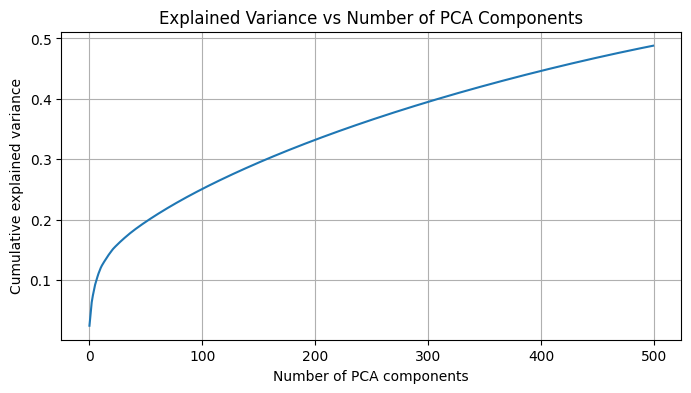

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.311986,0.505005,-1.720621,0.859438,-0.262897,-0.829213,-0.083454,0.179094,-0.815425,0.069385,...,0.065903,0.106516,0.028320,0.332818,-0.132132,0.041288,0.090543,-0.180958,0.222051,-0.115562
1,-1.329181,-0.768072,2.156692,-0.459450,-0.910574,-1.822129,0.067022,0.184919,0.079872,-1.171611,...,-0.015416,-0.021250,-0.129160,-0.011982,0.008632,-0.122674,0.106510,0.020485,0.018071,0.163923
2,-1.307191,-1.987664,0.836114,-0.119437,-1.263006,0.540450,-0.085223,0.015000,-0.499486,-0.002418,...,-0.139262,-0.087032,0.068724,0.090437,-0.072454,0.139520,0.018316,0.115261,0.036594,-0.006364


In [9]:
train_features = df_preprocessed_2_train_.values
val_features = df_preprocessed_2_val.values
top_components = 200
hog_train_pca_feature, pca_train_hog = pick_top_feature_pca(train_features, top_components, 500)
# Convert PCA transformed features to DataFrame
df_top_100_feature_pca_hog_train = pd.DataFrame(hog_train_pca_feature)
df_top_100_feature_pca_hog_train.head(3)

hog_val_pca_feature = pick_top_feature_pca_val_test(pca_train_hog, val_features, top_components)
df_top_100_feature_pca_hog_val = pd.DataFrame(hog_val_pca_feature)
df_top_100_feature_pca_hog_val.head(3)

In [ ]:
from joblib import dump, load
dump(pca_train_hog, '/content/drive/MyDrive/galaxy_zoo/pca_train_hog_3.joblib')

In [11]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler

def feature_normalization(df_feature):
  scaler = StandardScaler()
  normalized_features = scaler.fit_transform(df_feature.values)
  df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
  return df_normalized

In [12]:
df_top_100_feature_pca_hog_train_normalized = feature_normalization(df_top_100_feature_pca_hog_train)
df_top_100_feature_pca_hog_val_normalized = feature_normalization(df_top_100_feature_pca_hog_val)

In [13]:
Y_train_hog = df_train['label']
X_train_hog = df_top_100_feature_pca_hog_train_normalized.values

In [14]:
Y_val_hog = df_val['label']
X_val_hog = df_top_100_feature_pca_hog_val_normalized.values

In [15]:
print(X_train_pipeline1.shape, X_train_hog.shape, X_train_resnet.shape)
print(x_val_pipeline1.shape, X_val_hog.shape, X_val_resnet.shape)

NameError: name 'X_train_pipeline1' is not defined

In [16]:
df_X_train_hog = pd.DataFrame(X_train_hog)
df_x_val_hog = pd.DataFrame(X_val_hog)

df_X_train_hog.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_hog_3.csv", index=False)
df_x_val_hog.to_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_hog_3.csv", index=False)

In [17]:
X_train_pipeline1 = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_pipeline1_3.csv").values
X_train_hog = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_hog_3.csv").values
X_train_resnet = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_train_resnet_3.csv").values
x_val_pipeline1 = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_pipeline1_3.csv").values
X_val_hog = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_hog_3.csv").values
resnet_val_pca_feature = pd.read_csv("/content/drive/MyDrive/galaxy_zoo/df_X_val_resnet_3.csv").values

Combine all three sets of features

In [18]:
Y_train = df_train['label']
Y_val = df_val['label']

X_train = np.hstack([X_train_pipeline1, X_train_hog, X_train_resnet])
X_val = np.hstack([x_val_pipeline1, X_val_hog, resnet_val_pca_feature])
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(4863, 500) (608, 500) (4863,) (608,)


Post PCA (just wanna see the variance)

In [ ]:
top_components = 200
allpipeline_feature_train_pca, pca_all = pick_top_feature_pca(X_train, top_components, 500)
allpipeline_feature_val_pca = pick_top_feature_pca_val_test(pca_all, X_val, top_components)

In [ ]:
# X_train = allpipeline_feature_train_pca
# X_val = allpipeline_feature_val_pca

LDA + linear regression, cross validation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis(n_components = 4)
X_train_lda = lda.fit_transform(X_train, Y_train)
X_val_lda = lda.transform(X_val)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty='l1', C=1 , solver='liblinear')
classifier_l1.fit(X_train_lda, Y_train)

# training accuracy
y_pred = classifier_l1.predict(X_train_lda)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_train, y_pred)
print("training accuracy:", accuracy)

cv_scores = cross_val_score(classifier_l1, X_train_lda, Y_train, cv=5)
print("cross-val accuracy:", cv_scores.mean())

# before grid search
# n_componentsint = 4
# training accuracy: 0.8975
# cross-val accuracy: 0.8924999999999998

# n_componentsint = 3
# training accuracy: 0.884
# cross-val accuracy: 0.882

training accuracy: 0.850709438618137
cross-val accuracy: 0.8492693675747234


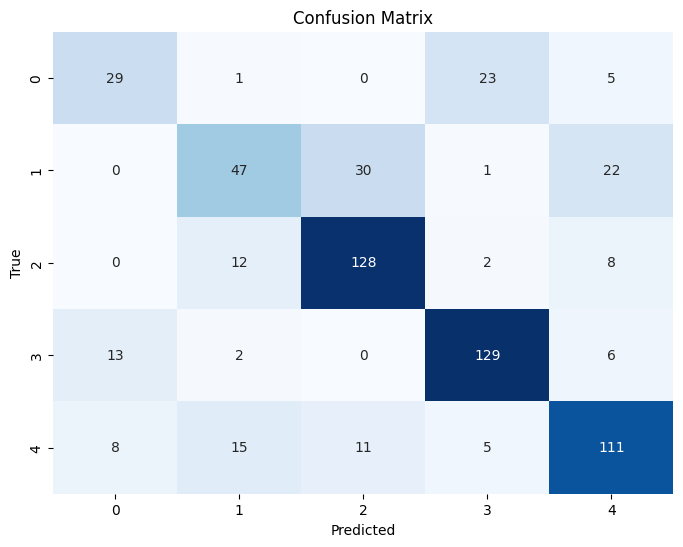

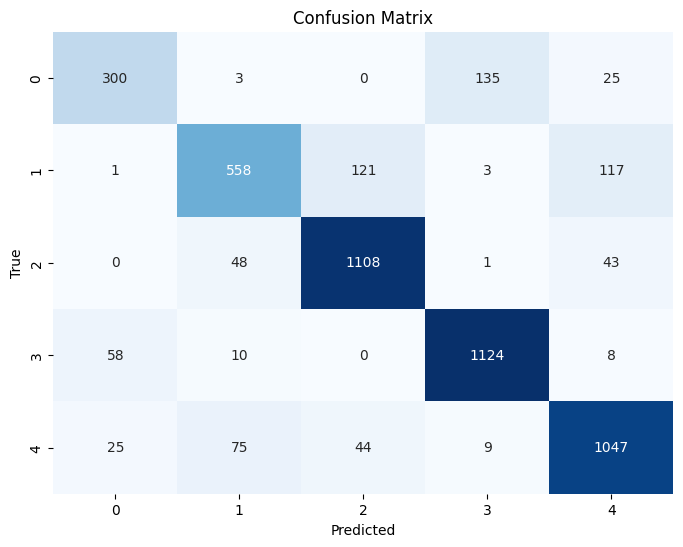

[[ 29   1   0  23   5]
 [  0  47  30   1  22]
 [  0  12 128   2   8]
 [ 13   2   0 129   6]
 [  8  15  11   5 111]]
[[ 300    3    0  135   25]
 [   1  558  121    3  117]
 [   0   48 1108    1   43]
 [  58   10    0 1124    8]
 [  25   75   44    9 1047]]


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrixy
conf_matrix_val = confusion_matrix(Y_train, classifier_l1.predict(X_train_lda))
conf_matrix_train = confusion_matrix(Y_val, classifier_l1.predict(X_val_lda))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(conf_matrix_train)
print(conf_matrix_val)

SVM, cross validation

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# train the SVM classifier
# C is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error.
# C represents the inverse of the regularization strength—smaller, C implies more regularization, larger, C implies less regularization
# poly, rbf, linear
svm_classifier = SVC(kernel='rbf', C=5, gamma=0.001)
svm_classifier.fit(X_train, Y_train)

# training accuracy
y_pred = svm_classifier.predict(X_train)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_train, y_pred)
print("training accuracy:", accuracy)

cv_scores = cross_val_score(svm_classifier, X_train, Y_train, cv=5)
print("cross-val accuracy:", cv_scores.mean())

# before grid search C = 1
# training accuracy: 0.9875
# cross-val accuracy: 0.7090000000000001

training accuracy: 0.9757351429158956
cross-val accuracy: 0.8075283688393201


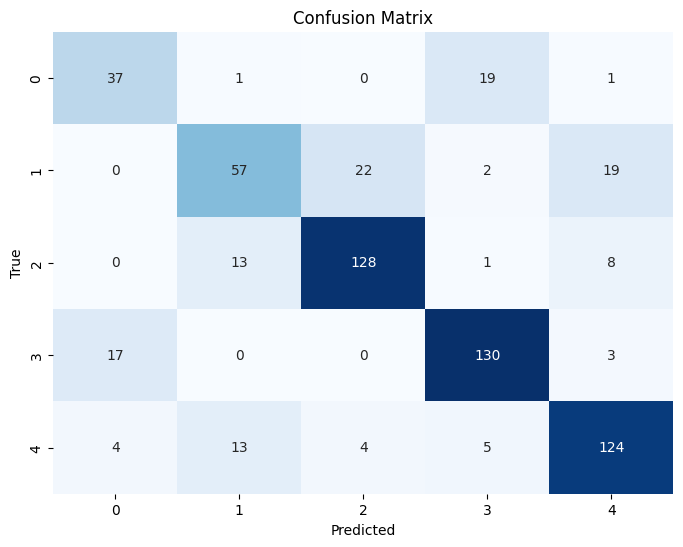

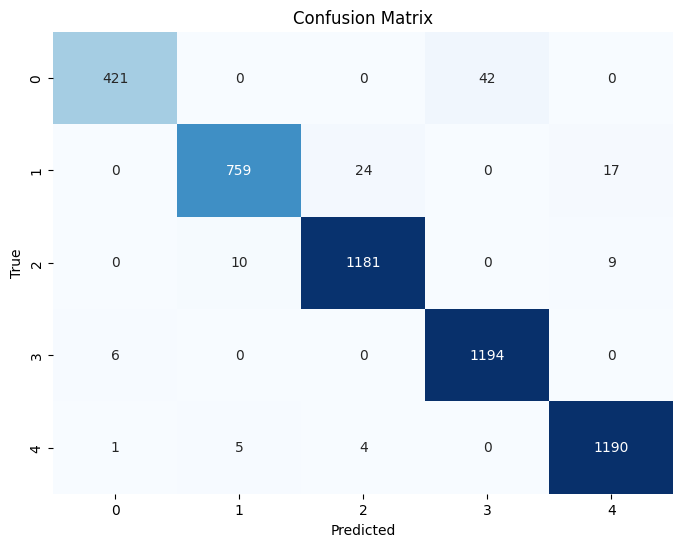

[[ 37   1   0  19   1]
 [  0  57  22   2  19]
 [  0  13 128   1   8]
 [ 17   0   0 130   3]
 [  4  13   4   5 124]]
[[ 421    0    0   42    0]
 [   0  759   24    0   17]
 [   0   10 1181    0    9]
 [   6    0    0 1194    0]
 [   1    5    4    0 1190]]


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrixy
conf_matrix_val = confusion_matrix(Y_train, svm_classifier.predict(X_train))
conf_matrix_train = confusion_matrix(Y_val, svm_classifier.predict(X_val))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(conf_matrix_train)
print(conf_matrix_val)

Test

pipeline resnet

In [23]:
# val data
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/test_data_3.csv'
column_names = ['path', 'index', 'label']
df_test = pd.read_csv(csv_file_path, names=column_names)
df_test = df_test.iloc[1:]
df_test = df_test.reset_index(drop=True)
print(df_test.shape)

(608, 3)


In [24]:
#load pca
from joblib import dump, load
pca_train_resnet = load('/content/drive/MyDrive/galaxy_zoo/pca_train_resnet_3.joblib')
pca_train_hog = load('/content/drive/MyDrive/galaxy_zoo/pca_train_hog_3.joblib')

In [25]:
images_list_nopreprocess_test = preprocess_resnet_nopreprocess(df_test)
print(len(images_list_nopreprocess_test))

100%|██████████| 608/608 [06:57<00:00,  1.46it/s]

608


In [33]:
# test
custom_dataset_test = CustomDataset(images_list_nopreprocess_test, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_test, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features_test = resnet(batch.to(device))
        features_list.append(features_test)

# Concatenate features from all batches
features_test = torch.cat(features_list, dim=0)

print(features_test.shape)

torch.Size([608, 2048, 1, 1])


In [34]:
import pandas as pd

features_test = features_test.cpu()
# reshape it to 2000,2048
reshaped_features_test = features_test.squeeze().numpy()
reshaped_features_test = reshaped_features_test.reshape(reshaped_features_test.shape[0], -1)
# Convert to DataFrame
df_features_test = pd.DataFrame(reshaped_features_test)
# Display the DataFrame
print(df_features_test.shape)
df_features_test.head(3)

(608, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.071567,0.218002,0.303137,0.451786,1.085515,0.745166,0.511673,0.738938,0.439530,0.236897,...,0.115883,0.393557,0.133479,0.044335,0.356906,0.135800,0.398717,0.183099,0.060696,0.263499
1,0.628641,0.252510,0.865765,0.237013,0.123498,0.903182,0.093575,0.110275,0.580228,0.752296,...,0.071696,0.531129,0.552846,0.577516,0.318722,0.302598,0.295424,0.242394,0.763206,0.748571
2,0.194194,0.749070,0.071209,0.164099,0.750281,0.660138,0.388318,0.694890,0.953955,0.188141,...,0.752394,0.416715,0.113439,0.304978,0.600702,0.199066,0.200566,0.119543,0.305480,0.528809


In [35]:
test_features = df_features_test.values
top_components = 100

resnet_test_pca_feature = pick_top_feature_pca_val_test(pca_train_resnet, test_features, top_components)
df_top_100_feature_pca_resnet_test = pd.DataFrame(resnet_test_pca_feature)
df_top_100_feature_pca_resnet_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-5.039637,1.030753,-0.013792,0.594013,0.131599,2.335538,-1.613700,2.148072,0.419497,-0.621275,...,-0.648687,-0.131867,0.732274,0.547060,0.121065,0.257043,0.900530,-0.497794,0.234804,-0.440145
1,3.611498,-1.674384,-4.578589,-0.618487,0.960087,-2.595675,-2.313337,-0.345931,2.241755,1.667706,...,0.936470,-0.915950,0.480767,0.239898,0.933223,0.004507,-0.155151,0.226783,-1.059339,-0.057903
2,-4.096614,6.024408,0.558229,4.899157,-0.540685,0.782900,-0.893281,-4.105796,-0.812297,-0.425120,...,0.023464,0.333853,-0.177813,-0.394545,0.361944,0.124548,-0.540896,-0.523298,-0.727765,0.172969


In [36]:
Y_test_resnet = df_test['label']
X_test_resnet = resnet_test_pca_feature
print(X_test_resnet.shape)

(608, 100)


pipeline1

In [38]:
with open("/content/drive/MyDrive/galaxy_zoo/codebook.npy", "rb") as f:
	codebook = np.load(f)
preprocessed_features_test = preprocess_1(df_test, codebook=codebook)
preprocessed_features_test.shape

100%|██████████| 608/608 [00:42<00:00, 14.23it/s]


(608, 200)

In [39]:
Y_val_pipeline1 = df_test['label']
max_test = np.max(preprocessed_features_test, axis=1)
vector_representations_normalized_test = preprocessed_features_test / max_test[:, np.newaxis]
x_test_pipeline1 = vector_representations_normalized_test

pipeline 2

In [40]:
df_preprocessed_2_test = preprocess_2(df_test)
df_preprocessed_2_test.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_test.columns))]
print(df_preprocessed_2_test.shape)

100%|██████████| 608/608 [01:45<00:00,  5.75it/s]


(608, 63504)


In [41]:
test_features = df_preprocessed_2_test.values
top_components = 200

hog_test_pca_feature = pick_top_feature_pca_val_test(pca_train_hog, test_features, top_components)
df_top_100_feature_pca_hog_test = pd.DataFrame(hog_test_pca_feature)
df_top_100_feature_pca_hog_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.170430,2.123957,0.099200,0.168365,-0.232829,1.624867,-0.544618,0.514845,0.938719,-0.680001,...,-0.001446,0.337818,0.075456,-0.236470,0.223467,-0.376816,0.205172,0.002459,-0.051251,0.069323
1,-1.470817,-2.070381,-1.149424,0.250828,1.298695,1.197517,0.412524,-0.547580,0.420781,0.108012,...,0.201887,-0.006295,-0.130425,-0.091246,0.187255,0.030171,0.186436,-0.092898,0.031522,-0.045679
2,-1.741302,1.808842,0.229397,0.361251,0.021891,1.318472,-0.832280,0.977809,0.646617,-0.429515,...,-0.074314,0.055030,-0.311884,-0.210241,-0.432793,-0.263050,0.281738,-0.092858,0.282731,0.112172


In [42]:
df_top_100_feature_pca_hog_test_normalized = feature_normalization(df_top_100_feature_pca_hog_test)

In [43]:
X_test_hog = df_top_100_feature_pca_hog_test_normalized.values

In [44]:
print(x_test_pipeline1.shape, X_test_hog.shape, resnet_test_pca_feature.shape)

(608, 200) (608, 200) (608, 100)


In [45]:
Y_test = df_test['label']

X_test = np.hstack([x_test_pipeline1, X_test_hog, resnet_test_pca_feature])
print(X_test.shape, Y_test.shape)

(608, 500) (608,)


In [46]:
# test accuracy
X_test_lda = lda.transform(X_test)
y_pred_test = classifier_l1.predict(X_test_lda)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred_test)
print("test accuracy:", accuracy)

test accuracy: 0.6858552631578947


In [47]:
# test accuracy

y_pred_test = svm_classifier.predict(X_test)
# evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred_test)
print("test accuracy:", accuracy)


# for data set having 2000 examples
"""
data set: reduced, 2000 examples, 500 for each
  -LDA + regression
    training accuracy: 0.8975
    cross-val accuracy: 0.8924999999999998
    testing accuracy: 0.708

  -SVM
    training accuracy: 0.9845
    cross-val accuracy: 0.726
    testing accuracy: 0.712


data set 2
  -LDA + regression
    training accuracy: 0.86479
    cross-val accuracy: 0.8648
    testing accuracy: 0.6818

  -SVM
    training accuracy: 0.9797
    cross-val accuracy: 0.7721
    testing accuracy:  0.7177


data set 3
  -LDA + regression
    training accuracy:
    cross-val accuracy:
    testing accuracy:

  -SVM
    training accuracy:
    cross-val accuracy:
    testing accuracy:
"""

# check confusion matrix

test accuracy: 0.8009868421052632


'\ndata set: reduced, 2000 examples, 500 for each\n  -LDA + regression\n    training accuracy: 0.8975\n    cross-val accuracy: 0.8924999999999998\n    testing accuracy: 0.708\n\n  -SVM\n    training accuracy: 0.9845\n    cross-val accuracy: 0.726\n    testing accuracy: 0.712\n\n\ndata set 2\n  -LDA + regression\n    training accuracy: 0.86479\n    cross-val accuracy: 0.8648\n    testing accuracy: 0.6818\n\n  -SVM\n    training accuracy: 0.9797\n    cross-val accuracy: 0.7721\n    testing accuracy:  0.7177\n\n\ndata set 3\n  -LDA + regression\n    training accuracy: \n    cross-val accuracy:\n    testing accuracy: \n\n  -SVM\n    training accuracy: \n    cross-val accuracy: \n    testing accuracy: \n'